<a href="https://colab.research.google.com/github/holly-hewitt/Abnormal-Infant-Movement-Detection/blob/main/Final_Window_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive


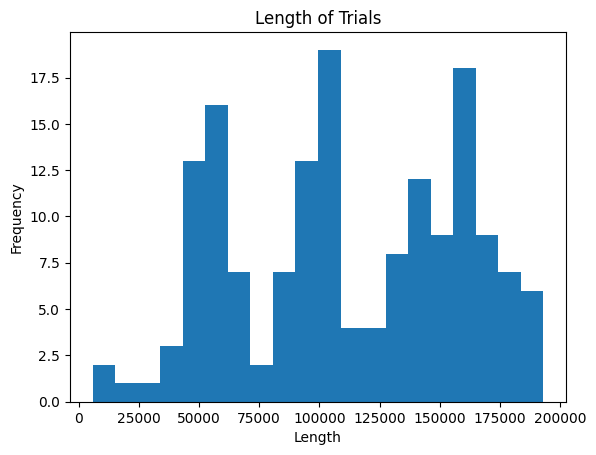

In [3]:
# import libraries
#import tensorflow.compat.v1 as tf
#tf.enable_eager_execution(tf.ConfigProto(log_device_placement=True))
#tf.test.gpu_device_name()
#tf.config.run_functions_eagerly(True)

#!pip install optuna
#!pip install optuna-integration

import tensorflow as tf
# Standard library imports
import datetime
import pickle
import gc

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler



# Keras/TensorFlow imports
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D, Normalization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

# Testing clasification using crossfold validation
from sklearn.model_selection import KFold
from keras.callbacks import EarlyStopping
from sklearn.metrics import precision_score, recall_score, accuracy_score
from keras.layers import Masking, LSTM, SimpleRNN, Bidirectional, GRU


tf.get_logger().setLevel('ERROR')

from google.colab import drive
drive.mount('/content/drive')

# open accelData pickle
with open('drive/MyDrive/Pickles/accelData.pickle', 'rb') as handle:
    accelData = pickle.load(handle)

# Remove time column from accelData Measurements
for i in range(len(accelData['Measurements'])):
    accelData['Measurements'][i] = accelData['Measurements'][i].iloc[:, 1:]

# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
for i in range(1):
    K = 14

    # Split some of the longer trials in half
    numRowsAccel = [df.shape[0] for df in accelData['Measurements']]
    sortedIndices = np.argsort(numRowsAccel)

    # Get the indices of the top k dataframes
    topKIndices = sortedIndices[-K:]

    # Get the top k dataframes
    topKDataframes = [accelData['Measurements'][i] for i in topKIndices]

    # Get the top k corresponding months, IDs, labels
    topKMonths = [accelData['Month'][i] for i in topKIndices]
    topKCodes = [accelData['Code'][i] for i in topKIndices]
    topKAbnormal = [accelData['Abnormal'][i] for i in topKIndices]
    topKAIMS = [accelData['AIMS'][i] for i in topKIndices]
    topKOptimality = [accelData['Optimality'][i] for i in topKIndices]

    # Remove the dataframes from accelData
    for i in sorted(topKIndices, reverse=True):
        del accelData['Measurements'][i]
        del accelData['Month'][i]
        del accelData['Code'][i]
        del accelData['Abnormal'][i]
        del accelData['AIMS'][i]
        del accelData['Optimality'][i]

    # Split the top k dataframes into two and reinsert into structure
    for i in range(len(topKDataframes)):
        df = topKDataframes[i]
        month = topKMonths[i]
        code = topKCodes[i]
        abnormal = topKAbnormal[i]
        aims = topKAIMS[i]
        optimality = topKOptimality[i]

        first_half = df.iloc[0:df.shape[0]//2]
        second_half = df.iloc[df.shape[0]//2:df.shape[0]]

        # Append the first and second halves to accelData
        accelData['Measurements'].append(first_half)
        accelData['Measurements'].append(second_half)

        # Append the corresponding values for month, code, abnormal, aims, and optimality
        accelData['Month'].extend([month, month])
        accelData['Code'].extend([code, code])
        accelData['Abnormal'].extend([abnormal, abnormal])
        accelData['AIMS'].extend([aims, aims])
        accelData['Optimality'].extend([optimality, optimality])

    # PLot histogram of length of trials
    lengths = [len(accelData['Measurements'][i]) for i in range(len(accelData['Measurements']))]
    plt.hist(lengths, bins=20)
    plt.title("Length of Trials")
    plt.xlabel("Length")
    plt.ylabel("Frequency")
    plt.show()

    # Memory management
    del numRowsAccel, sortedIndices, topKIndices, topKDataframes, topKMonths, topKCodes, topKAbnormal, topKAIMS, topKOptimality, first_half, second_half, df, month, code, abnormal, aims, optimality

# start making visualizations of the data.
try:
    i = accelData['Abnormal'].index(0.5)

    del accelData['Measurements'][i], accelData['Month'][i], accelData['Code'][i], accelData['Abnormal'][i], accelData['AIMS'][i], accelData['Optimality'][i]
except:
    pass


# get specific rows from dataframes in accelData Measurements
RA_cols = ['AccXRA', 'AccYRA', 'AccZRA']
LA_cols = ['AccXLA', 'AccYLA', 'AccZLA']
RW_cols = ['AccXRW', 'AccYRW', 'AccZRW']
LW_cols = ['AccXLW', 'AccYLW', 'AccZLW']


sum_cols = ['AccSumRA', 'AccSumLA', 'AccSumRW', 'AccSumLW']

#sum = [df[sum_cols] for df in accelData['Measurements']]

abnormal = accelData['Abnormal']
AIMS = accelData['AIMS']
Optimality = accelData['Optimality']
measurements = accelData['Measurements']
months = accelData['Month']
codes = accelData['Code']


measurements_nosum_cols = ['AccXRA', 'AccYRA', 'AccZRA', 'AccXLA', 'AccYLA', 'AccZLA', 'AccXRW', 'AccYRW', 'AccZRW', 'AccXLW', 'AccYLW', 'AccZLW']
measurements_nosum = [df[measurements_nosum_cols] for df in accelData['Measurements']]

del accelData

In [4]:
standardised = []
for df in measurements_nosum:
    scaler = StandardScaler()
    array = scaler.fit_transform(df)
    standardised_df = pd.DataFrame(array, columns=df.columns, index=df.index)
    standardised.append(standardised_df)

normalised = []
for df in measurements_nosum:
    scaler = MinMaxScaler()
    array = scaler.fit_transform(df)  # Fit and transform the data
    normalised_df = pd.DataFrame(array, columns=df.columns, index=df.index)  # Create a new DataFrame
    normalised.append(normalised_df)

In [5]:
def prepare_data(trials, labels, window_size, stride):
    all_windows = []
    all_labels = []

    # Loop over each trial and its corresponding label
    for trial, label in zip(trials, labels):
        # Create windows for the current trial
        windows = create_windows(trial, window_size, stride)

        # Extend the list of all windows with the newly created windows
        all_windows.extend(windows)

        # Extend the list of all labels with the current label repeated for each window created from the current trial
        all_labels.extend([label] * len(windows))

    return all_windows, all_labels

def create_windows(data, window_size, stride):
    return [data[i:i + window_size] for i in range(0, len(data) - window_size, stride)]

In [11]:
def majority_concat(trial, upperBound, lowerBound):
    trial = np.array(trial)
    # normal count is all of the entries that are >0.5
    normal_count = np.count_nonzero(trial > upperBound)
    abnormal_count = np.count_nonzero(trial < lowerBound)
    #abnormal_count = len(trial) - normal_count
    prediction = np.mean(trial)
    if normal_count > abnormal_count:
        return 1
    else:
        return 0

def mean_concat(trial, upperBound):
    trial = np.array(trial)
    mean = np.mean(trial)
    if mean > upperBound:
        return 1
    else:
        return 0
    #return np.mean(trial)

def median_concat(trial, upperBound):
    trial = np.array(trial)
    median = np.median(trial)
    if median > upperBound:
        return 1
    else:
        return 0

def sequential_threshold(trial, threshold, sequence_length):
    """
    Apply sequential thresholding to make a trial prediction.

    Parameters:
        trial (np.array): An array of predictions for each window in the trial.
        threshold (float): The threshold for considering a prediction as indicating a particular outcome (e.g., abnormal).
        sequence_length (int): The minimum number of consecutive predictions above the threshold required to predict the trial as abnormal.

    Returns:
        int: The trial prediction (1 for abnormal if the sequence condition is met, 0 otherwise).
    """
    # Convert trial to a binary sequence based on the threshold
    binary_sequence = np.where(trial > threshold, 1, 0)

    # Check for consecutive sequences of 1s
    for i in range(len(binary_sequence) - sequence_length + 1):
        if np.all(binary_sequence[i:i+sequence_length] == 1):
            return 1  # Return 1 if a sequence meeting the criteria is found

    return 0

def create_CNN_model(input_shape):
    model = Sequential()
   # Convolutional Layer 1
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Convolutional Layer 2
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))

    # Flattening the layers
    model.add(Flatten())

    # Dense Layer 1
    model.add(Dense(units=32, activation='relu'))
    model.add(Dropout(0.5))

    # Output Layer
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def assess_window_model(train_data,
                        model_fn,
                        convert_predictions,
                        fn_arg1=None,
                        fn_arg2=None,
                        verbose=False,
                        windowSize=500,
                        stride=250 ):

    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    str_codes = [str(x) for x in codes]
    unique_codes = np.unique(str_codes)

    fold = 0

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    false_positive_rates = []
    specificity_scores = []

    for train_index, test_index in outer_cv.split(unique_codes):

        # Update progress
        fold += 1

        # Split data into train and test
        train_codes = unique_codes[train_index]
        test_codes = unique_codes[test_index]

        train_measurements = [df for i, df in enumerate(train_data) if str_codes[i] in train_codes]
        test_measurements = [df for i, df in enumerate(train_data) if str_codes[i] in test_codes]

        train_abnormal = np.array([abnormal for i, abnormal in enumerate(abnormal) if str_codes[i] in train_codes])
        test_abnormal = np.array([abnormal for i, abnormal in enumerate(abnormal) if str_codes[i] in test_codes])

        # Split train_measurments into windows
        windows, labels = prepare_data(train_measurements, train_abnormal, windowSize, stride)

        # Normalise windows
        windows = np.array(windows)
        #scaler = StandardScaler()
        #normalised_windows = [scaler.fit_transform(window) for window in windows]
        normalised_windows = windows

        # Train the model
        model = model_fn(normalised_windows[0].shape)
        callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
        batch_size = len(normalised_windows)//500
        if verbose:
            print('Fitting model...')
        model.fit(np.array(normalised_windows), np.array(labels), epochs=10, batch_size=batch_size, callbacks=callbacks, validation_split=0.1, verbose=0)
        if verbose:
            print('Model fitted.')

        # Make predictions

        # Split test_measurements into windows
        test_windows = []
        for trial in test_measurements:
            windows = create_windows(trial, windowSize, stride)
            #windows = [scaler.fit_transform(window) for window in windows]
            test_windows.append(windows)

        # For each set of windows in test_windows, make predictions
        test_predictions = []
        for trial in test_windows:
            preds = model.predict(np.array(trial), verbose=0)
            test_predictions.append(preds)

        # Make an overall trial prediction
        predictions = []
        for i, trial in enumerate(test_predictions):
            # plot the predictions
            #if verbose:
            #    plt.plot(trial)
            #    plt.show()
            if fn_arg2 is not None:
                pred = convert_predictions(trial, fn_arg1, fn_arg2)
            else:
                pred = convert_predictions(trial, fn_arg1)
            predictions.append(pred)
            #print(f"Trial {i} prediction: {pred}, label: {test_abnormal[i]}")


        predictions = np.array(predictions)

        # Calculate metrics
        tf.keras.backend.clear_session()
        gc.collect()

        accuracy = accuracy_score(test_abnormal, predictions.round())
        precision = precision_score(test_abnormal, predictions.round())
        recall = recall_score(test_abnormal, predictions.round())

        false_positives = np.logical_and(predictions > 0.5, test_abnormal == 0).sum()
        true_negatives = np.logical_and(predictions <= 0.5, test_abnormal == 0).sum()
        total_negatives = (test_abnormal == 0).sum()

        specificity = true_negatives / (true_negatives + false_positives)
        false_positive_rate = false_positives / (false_positives + true_negatives)

        if verbose:
            print("Results for fold:", fold)
            print(f"Accuracy: {accuracy}, Recall: {recall}, False Positives: {false_positive_rate}, Specificity: {specificity}, Precision: {precision}.")

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        false_positive_rates.append(false_positive_rate)
        specificity_scores.append(specificity)

    # find average of each score
    avg_accuracy = np.mean(accuracy_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_false_positive_rate = np.mean(false_positive_rates)
    avg_specificity = np.mean(specificity_scores)

    # find standard deviation of each score
    std_accuracy = np.std(accuracy_scores)
    std_precision = np.std(precision_scores)
    std_recall = np.std(recall_scores)
    std_false_positive_rate = np.std(false_positive_rates)
    std_specificity = np.std(specificity_scores)

    print("Results for all folds:")
    print(f"Accuracy: {avg_accuracy}(+/- {std_accuracy}) Recall: {avg_recall}(+/- {std_recall}), False Positive Rate: {avg_false_positive_rate} (+/- {std_false_positive_rate}), Specificity: {avg_specificity} (+/- {std_specificity}), Precision: {avg_precision} (+/- {std_precision}).")

    return avg_accuracy, avg_precision, avg_recall, avg_false_positive_rate, avg_specificity

Mean Concatenation method testing

In [13]:
# Testing MEAN with normalised data
thresholds = [0.3, 0.4, 0.45, 0.5]
mean_results_normalised = {}
for mean_threshold in thresholds:
    # Print status
    print(f"Mean threshold: {mean_threshold}")
    CNN_mean_normalised = assess_window_model(normalised, create_CNN_model, mean_concat, fn_arg1=mean_threshold, verbose=False)
    mean_results_normalised[mean_threshold] = CNN_mean_normalised

Mean threshold: 0.3
Results for all folds:
Accuracy: 0.4466534179385733(+/- 0.04015328867357826) Recall: 0.5709595959595959(+/- 0.16806195868471596), False Positive Rate: 0.6322377622377623 (+/- 0.12895545637471267), Specificity: 0.36776223776223776 (+/- 0.1289554563747127), Precision: 0.3551003344481606 (+/- 0.10819551453270101).
Mean threshold: 0.4
Results for all folds:
Accuracy: 0.49375991937001756(+/- 0.04206623801939831) Recall: 0.4328282828282828(+/- 0.14969955967715443), False Positive Rate: 0.47192307692307695 (+/- 0.06707762878951275), Specificity: 0.528076923076923 (+/- 0.06707762878951273), Precision: 0.3597549019607843 (+/- 0.13629640817142102).
Mean threshold: 0.45
Results for all folds:
Accuracy: 0.5135154538136748(+/- 0.07051142268703725) Recall: 0.43686868686868685(+/- 0.1246155192993223), False Positive Rate: 0.44495337995337997 (+/- 0.13594216738738266), Specificity: 0.5550466200466201 (+/- 0.13594216738738268), Precision: 0.38531468531468527 (+/- 0.1435769717021431)

In [14]:
# Testing MEAN with normalised data
thresholds = [0.55, 0.6, 0.65, 0.7]
mean_results_normalised = {}
for mean_threshold in thresholds:
    # Print status
    print(f"Mean threshold: {mean_threshold}")
    CNN_mean_normalised = assess_window_model(normalised, create_CNN_model, mean_concat, fn_arg1=mean_threshold, verbose=False)
    mean_results_normalised[mean_threshold] = CNN_mean_normalised

Mean threshold: 0.55
Results for all folds:
Accuracy: 0.5584726894374786(+/- 0.12539977116568524) Recall: 0.2689393939393939(+/- 0.07821763332812307), False Positive Rate: 0.2812470862470863 (+/- 0.13889593040218737), Specificity: 0.7187529137529138 (+/- 0.13889593040218737), Precision: 0.3916883116883117 (+/- 0.09890819054484888).
Mean threshold: 0.6
Results for all folds:
Accuracy: 0.5037796518581932(+/- 0.07584674323731086) Recall: 0.2621212121212121(+/- 0.12490584148803), False Positive Rate: 0.3474475524475525 (+/- 0.12223011645324322), Specificity: 0.6525524475524476 (+/- 0.12223011645324322), Precision: 0.32047619047619047 (+/- 0.15459404816451103).
Mean threshold: 0.65
Results for all folds:
Accuracy: 0.5946571516129352(+/- 0.12160729726365592) Recall: 0.2732323232323232(+/- 0.10519609181373801), False Positive Rate: 0.23623543123543125 (+/- 0.11845239206623875), Specificity: 0.7637645687645688 (+/- 0.11845239206623875), Precision: 0.43116161616161613 (+/- 0.14395335746553264).

In [15]:
# Testing MEAN with standardised data
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
mean_results_standardised = {}
for mean_threshold in thresholds:
    # Print status
    print(f"Mean threshold: {mean_threshold}")
    CNN_mean_standardised = assess_window_model(standardised, create_CNN_model, mean_concat, fn_arg1=mean_threshold, verbose=False)
    mean_results_standardised[mean_threshold] = CNN_mean_standardised

Mean threshold: 0.3
Results for all folds:
Accuracy: 0.5250632637950863(+/- 0.1381025005822477) Recall: 0.7989898989898989(+/- 0.1341724437763259), False Positive Rate: 0.5856293706293706 (+/- 0.18985975922954343), Specificity: 0.4143706293706294 (+/- 0.18985975922954343), Precision: 0.46260139860139865 (+/- 0.1838970021587892).
Mean threshold: 0.4
Results for all folds:
Accuracy: 0.5166354366088625(+/- 0.053095060771237566) Recall: 0.4416666666666666(+/- 0.3071276030490214), False Positive Rate: 0.35614219114219114 (+/- 0.23328040705758188), Specificity: 0.6438578088578089 (+/- 0.23328040705758196), Precision: 0.42642857142857143 (+/- 0.2504445027937164).
Mean threshold: 0.5
Results for all folds:
Accuracy: 0.551309058058892(+/- 0.06317314912735764) Recall: 0.23106060606060605(+/- 0.21638039999569203), False Positive Rate: 0.18727272727272729 (+/- 0.16153135401135585), Specificity: 0.8127272727272727 (+/- 0.16153135401135582), Precision: 0.381203007518797 (+/- 0.3501661251808213).
Mea

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Results for all folds:
Accuracy: 0.6060634053577141(+/- 0.11755063468383202) Recall: 0.0(+/- 0.0), False Positive Rate: 0.013333333333333332 (+/- 0.026666666666666665), Specificity: 0.9866666666666667 (+/- 0.02666666666666666), Precision: 0.0 (+/- 0.0).
Mean threshold: 0.7


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for all folds:
Accuracy: 0.6113265632524509(+/- 0.12371569396165134) Recall: 0.0(+/- 0.0), False Positive Rate: 0.006666666666666666 (+/- 0.013333333333333332), Specificity: 0.9933333333333334 (+/- 0.01333333333333333), Precision: 0.0 (+/- 0.0).


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Median Concatenation Testing

In [16]:
# Testing MEDIAN with normalised data
thresholds = [0.2, 0.3, 0.4, 0.5]
median_results_normalised = {}
for median_threshold in thresholds:
    # Print status
    print(f"Median threshold: {median_threshold}")
    CNN_median_normalised = assess_window_model(normalised, create_CNN_model, median_concat, fn_arg1=median_threshold, verbose=False)
    median_results_normalised[median_threshold] = CNN_median_normalised

Median threshold: 0.2
Results for all folds:
Accuracy: 0.5036343376610594(+/- 0.06373042996527573) Recall: 0.572979797979798(+/- 0.21092798108059163), False Positive Rate: 0.4896503496503497 (+/- 0.15932898671210152), Specificity: 0.5103496503496503 (+/- 0.15932898671210155), Precision: 0.4142890442890443 (+/- 0.16031995519135467).
Median threshold: 0.3
Results for all folds:
Accuracy: 0.4899965392251507(+/- 0.07511617719454732) Recall: 0.40858585858585855(+/- 0.21341835235787643), False Positive Rate: 0.41502331002331 (+/- 0.10676024012325676), Specificity: 0.58497668997669 (+/- 0.10676024012325677), Precision: 0.3411782420478073 (+/- 0.06528961263441257).
Median threshold: 0.4
Results for all folds:
Accuracy: 0.5434120427934557(+/- 0.053483784108890466) Recall: 0.32626262626262625(+/- 0.11372499349525308), False Positive Rate: 0.2772027972027972 (+/- 0.1217091432710497), Specificity: 0.7227972027972027 (+/- 0.1217091432710497), Precision: 0.4315384615384616 (+/- 0.1928975568938635).


In [17]:
# Testing MEDIAN with standardised data
thresholds = [0.2, 0.3, 0.4, 0.5]
median_results_standardised = {}
for median_threshold in thresholds:
    # Print status
    print(f"Median threshold: {median_threshold}")
    CNN_median_standardised = assess_window_model(standardised, create_CNN_model, median_concat, fn_arg1=median_threshold, verbose=False)
    median_results_standardised[median_threshold] = CNN_median_standardised

Median threshold: 0.2
Results for all folds:
Accuracy: 0.4961231971935449(+/- 0.18199957041634318) Recall: 0.8282828282828284(+/- 0.12288409152117616), False Positive Rate: 0.6756526806526806 (+/- 0.19468599428071331), Specificity: 0.3243473193473193 (+/- 0.1946859942807133), Precision: 0.44171717171717173 (+/- 0.17393739953572165).
Median threshold: 0.3
Results for all folds:
Accuracy: 0.5408080509829973(+/- 0.12350106126064167) Recall: 0.6429292929292929(+/- 0.16427422754195706), False Positive Rate: 0.4934965034965034 (+/- 0.20636291886760172), Specificity: 0.5065034965034966 (+/- 0.20636291886760177), Precision: 0.461437908496732 (+/- 0.22753548126084172).
Median threshold: 0.4
Results for all folds:
Accuracy: 0.5306990541507408(+/- 0.059344901630482984) Recall: 0.45707070707070707(+/- 0.17985755453829985), False Positive Rate: 0.38706293706293704 (+/- 0.16051976665468712), Specificity: 0.612937062937063 (+/- 0.16051976665468715), Precision: 0.41938616938616935 (+/- 0.1923587007453

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Results for all folds:
Accuracy: 0.5645305409386018(+/- 0.061683526940688314) Recall: 0.20176767676767676(+/- 0.2194274440997771), False Positive Rate: 0.16166666666666668 (+/- 0.1601735170231195), Specificity: 0.8383333333333333 (+/- 0.16017351702311952), Precision: 0.38888888888888895 (+/- 0.34605358894216526).


Majority Concatenation Testing

In [ ]:
# Testing MAJORITY VOTE with normalised data
upper_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
lower_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
majority_results_normalised = {}

for upper_threshold in upper_thresholds:
    for lower_threshold in lower_thresholds:
        # Print status
        print(f"----------------Upper Threshold: {upper_threshold}, Lower Threshold: {lower_threshold}------------------")
        CNN_majority_normalised = assess_window_model(normalised, create_CNN_model, majority_concat, fn_arg1=upper_threshold, fn_arg2=lower_threshold, verbose=False)
        majority_results_normalised[(upper_threshold, lower_threshold)] = CNN_majority_normalised

----------------Upper Threshold: 0.5, Lower Threshold: 0.1------------------


In [ ]:
# Testing MAJORITY VOTE with standardised data
upper_thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
lower_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
majority_results_standardised = {}

for upper_threshold in upper_thresholds:
    for lower_threshold in lower_thresholds:
        # Print status
        print(f"Upper Threshold: {upper_threshold}, Lower Threshold: {lower_threshold}")
        CNN_majority_standardised = assess_window_model(standardised, create_CNN_model, majority_concat, fn_arg1=upper_threshold, fn_arg2=lower_threshold, verbose=True)
        majority_results_standardised[(upper_threshold, lower_threshold)] = CNN_majority_standardised

Sequential Threshold Testing

In [ ]:
# Testing SEQUENTIAL THRESHOLDING with normalised data
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
sequence_lengths = [4, 6, 8, 10]

sequential_results_normalised = {}

for threshold in thresholds:
    for sequence_length in sequence_lengths:
        # Print status
        print(f"Threshold: {threshold}, Sequence Length: {sequence_length}")
        CNN_sequential_normalised = assess_window_model(normalised, create_CNN_model, sequential_threshold, fn_arg1=threshold, fn_arg2=sequence_length, verbose=True)
        sequential_results_normalised[(threshold, sequence_length)] = CNN_sequential_normalised

In [ ]:
# Testing SEQUENTIAL THRESHOLDING with standardised data
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9]
sequence_lengths = [4, 6, 8, 10]

sequential_results_standardised = {}

for threshold in thresholds:
    for sequence_length in sequence_lengths:
        # Print status
        print(f"Threshold: {threshold}, Sequence Length: {sequence_length}")
        CNN_sequential_standardised = assess_window_model(standardised, create_CNN_model, sequential_threshold, fn_arg1=threshold, fn_arg2=sequence_length, verbose=True)
        sequential_results_standardised[(threshold, sequence_length)] = CNN_sequential_standardised

Epoch 1/10
451/451 [==============================] - 6s 8ms/step - loss: 0.6468 - accuracy: 0.6592 - val_loss: 0.6875 - val_accuracy: 0.7538
Epoch 2/10
451/451 [==============================] - 3s 7ms/step - loss: 0.5832 - accuracy: 0.6845 - val_loss: 0.7081 - val_accuracy: 0.7487
Epoch 3/10
451/451 [==============================] - 3s 6ms/step - loss: 0.5558 - accuracy: 0.7023 - val_loss: 0.5955 - val_accuracy: 0.7910
Epoch 4/10
451/451 [==============================] - 3s 7ms/step - loss: 0.5337 - accuracy: 0.7145 - val_loss: 0.5976 - val_accuracy: 0.7555
Epoch 5/10
451/451 [==============================] - 3s 7ms/step - loss: 0.5112 - accuracy: 0.7257 - val_loss: 0.6678 - val_accuracy: 0.7550
Epoch 6/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4926 - accuracy: 0.7372 - val_loss: 0.5925 - val_accuracy: 0.7681
Epoch 7/10
451/451 [==============================] - 3s 6ms/step - loss: 0.4724 - accuracy: 0.7489 - val_loss: 0.6134 - val_accuracy: 0.7990
Epoch 

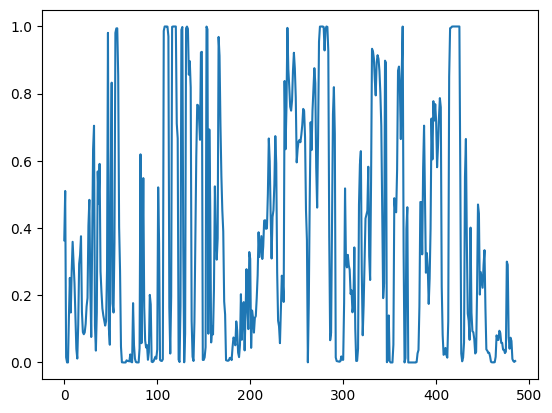

Trial 0 prediction: 0.3597564697265625, label: 1.0


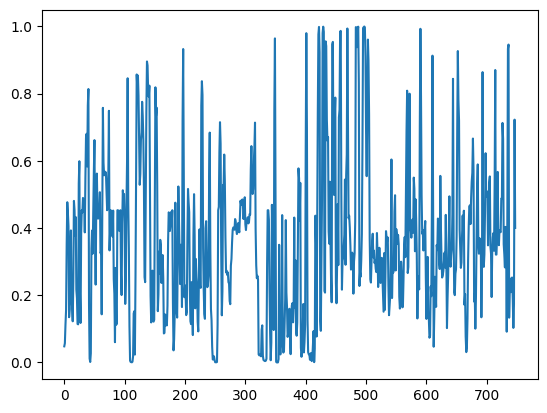

Trial 1 prediction: 0.3662596642971039, label: 1.0


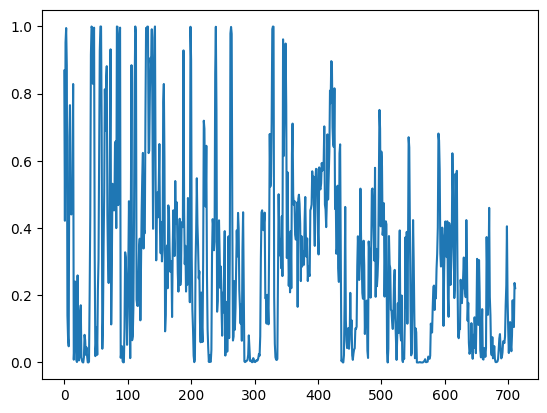

Trial 2 prediction: 0.30986857414245605, label: 1.0


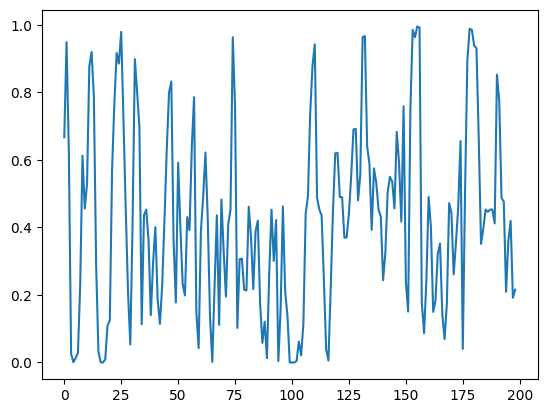

Trial 3 prediction: 0.42278775572776794, label: 1.0


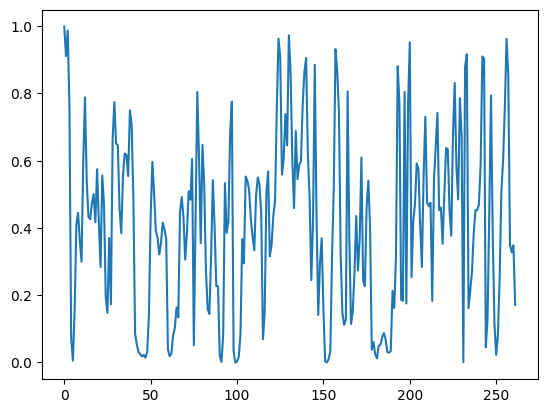

Trial 4 prediction: 0.41388481855392456, label: 1.0


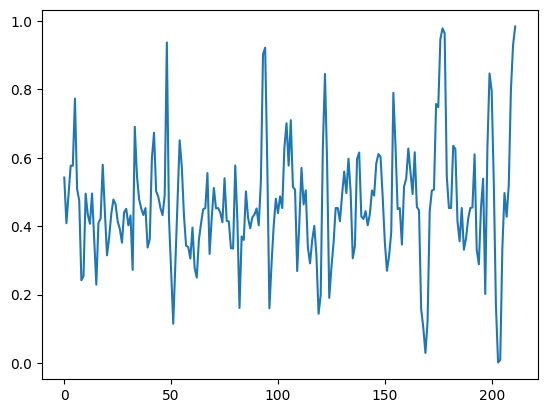

Trial 5 prediction: 0.4622551500797272, label: 1.0


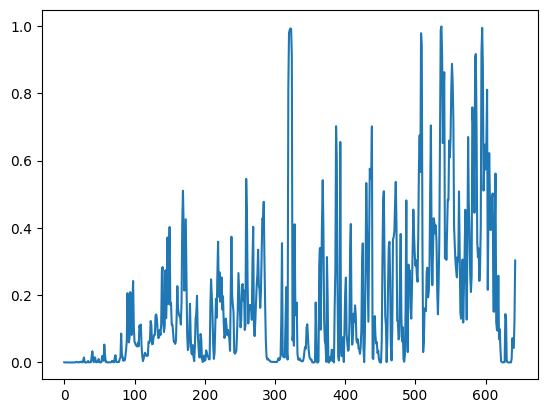

Trial 6 prediction: 0.1811007410287857, label: 1.0


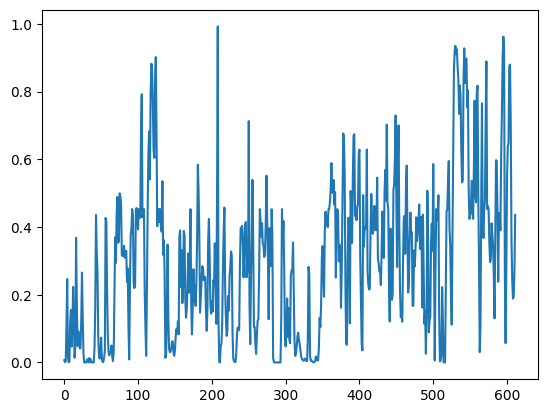

Trial 7 prediction: 0.30352768301963806, label: 1.0


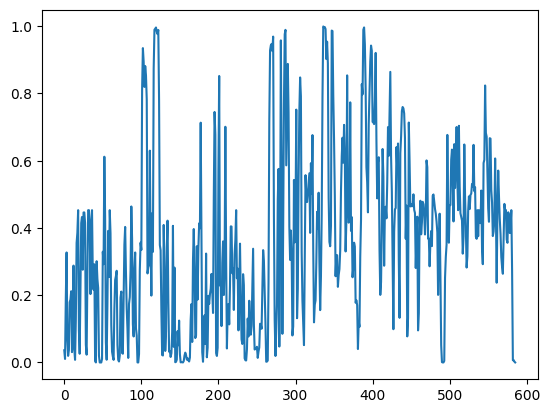

Trial 8 prediction: 0.36657190322875977, label: 1.0


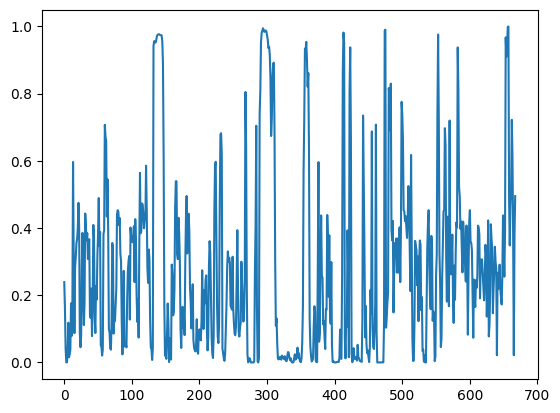

Trial 9 prediction: 0.2846285104751587, label: 0.0


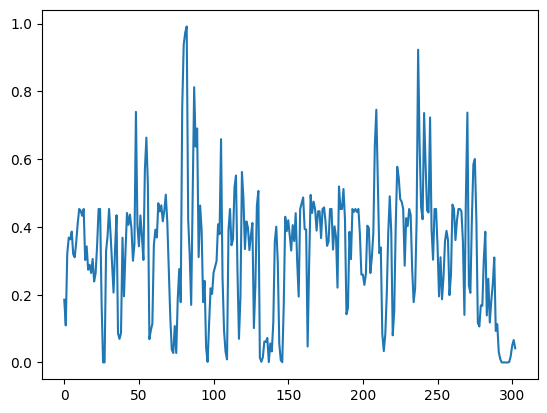

Trial 10 prediction: 0.3290960192680359, label: 1.0


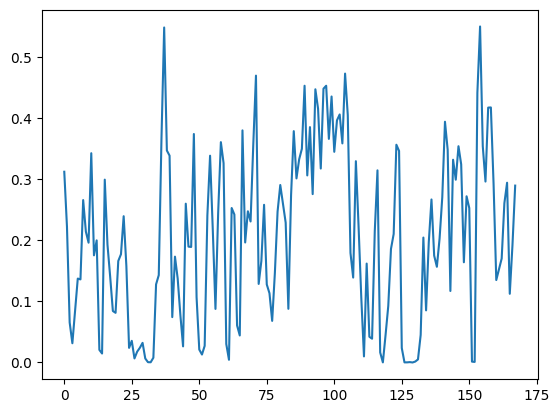

Trial 11 prediction: 0.20423156023025513, label: 0.0


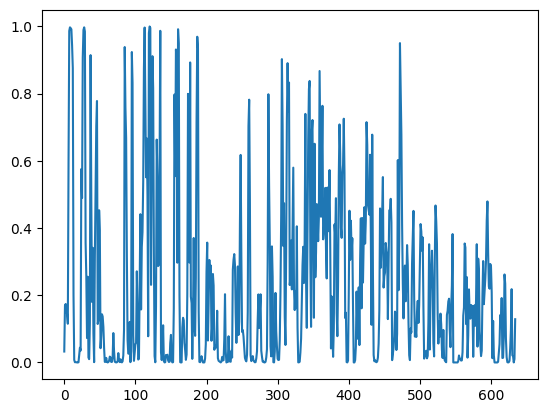

Trial 12 prediction: 0.23346742987632751, label: 0.0


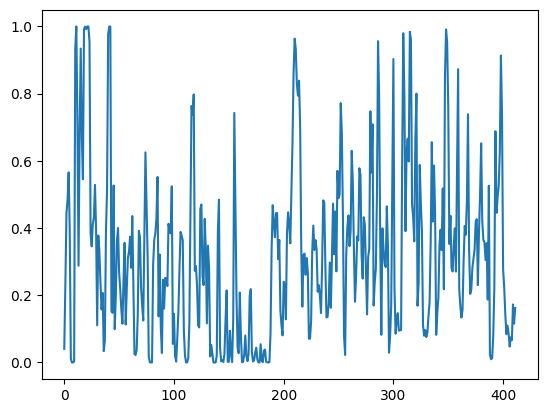

Trial 13 prediction: 0.3229990005493164, label: 0.0


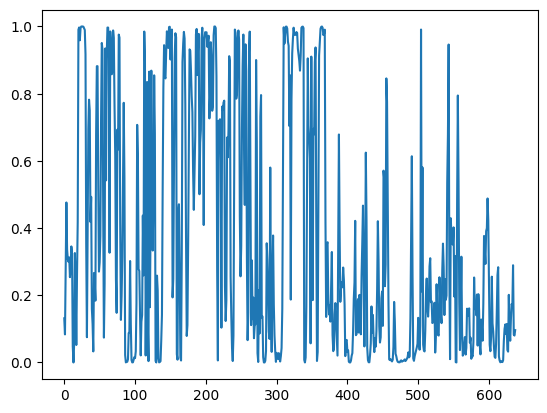

Trial 14 prediction: 0.37941741943359375, label: 0.0


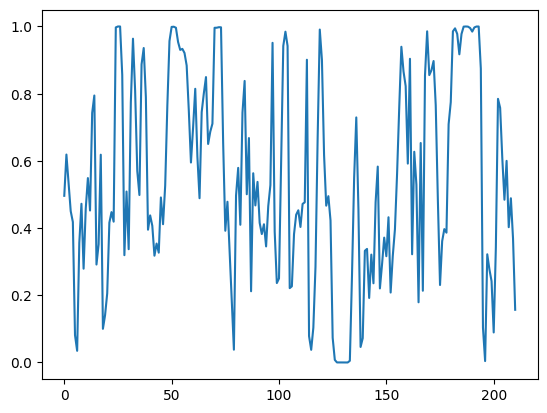

Trial 15 prediction: 0.5442450046539307, label: 1.0


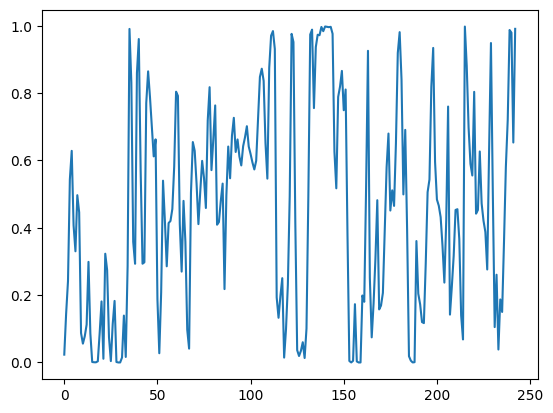

Trial 16 prediction: 0.46103301644325256, label: 1.0


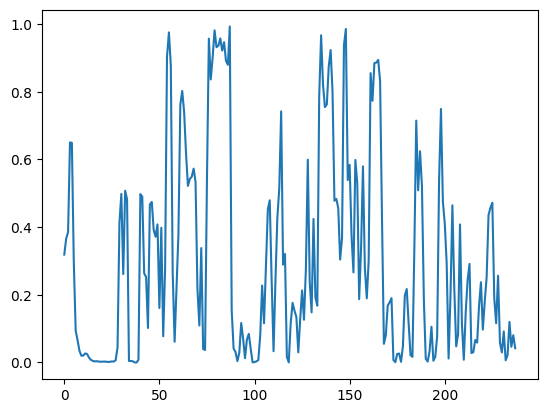

Trial 17 prediction: 0.309330016374588, label: 1.0


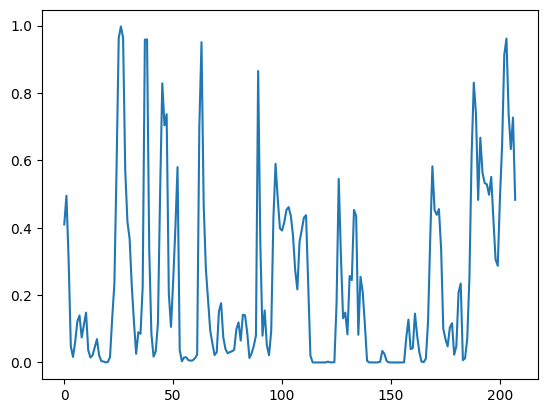

Trial 18 prediction: 0.23282064497470856, label: 1.0


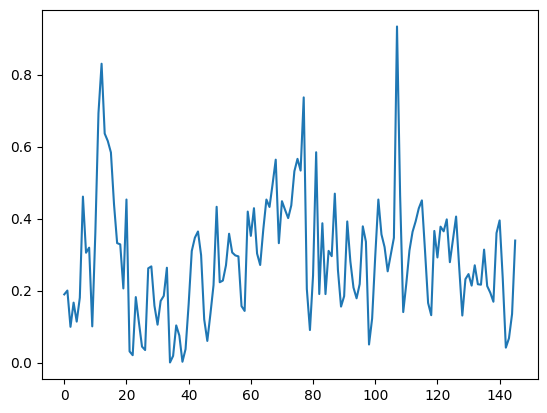

Trial 19 prediction: 0.29004910588264465, label: 0.0


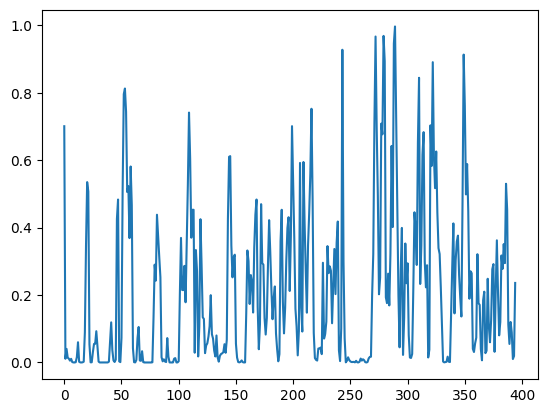

Trial 20 prediction: 0.20976829528808594, label: 0.0


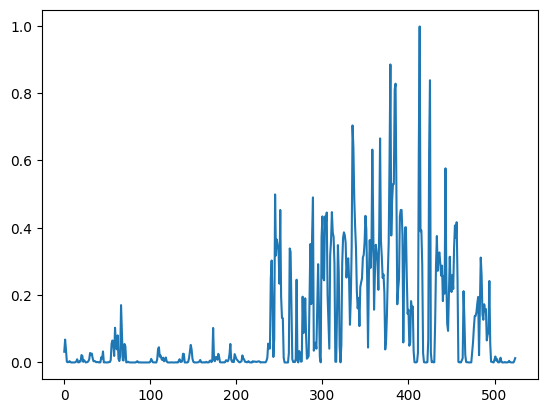

Trial 21 prediction: 0.11225719004869461, label: 0.0


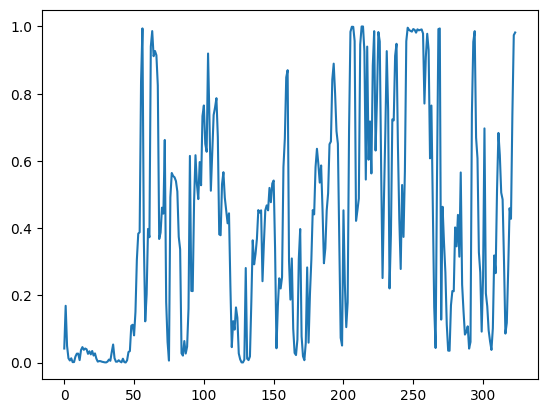

Trial 22 prediction: 0.4039332866668701, label: 0.0


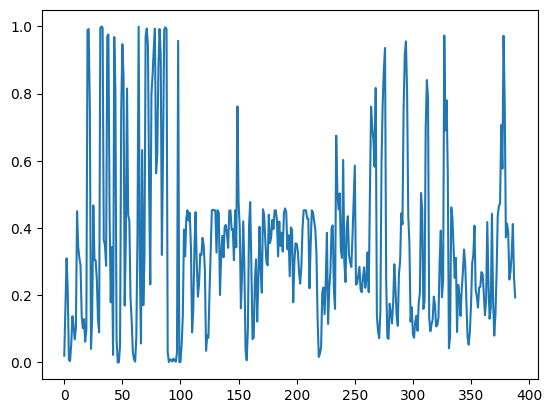

Trial 23 prediction: 0.34747427701950073, label: 1.0


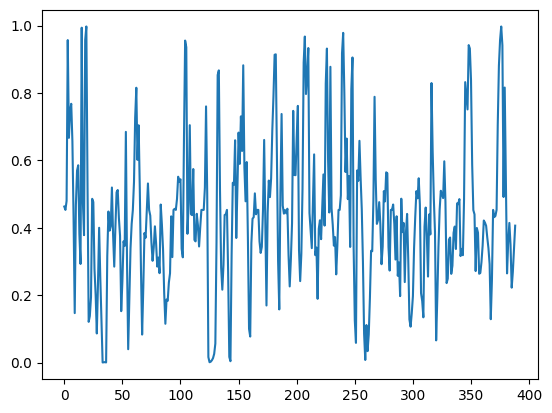

Trial 24 prediction: 0.4355852007865906, label: 1.0


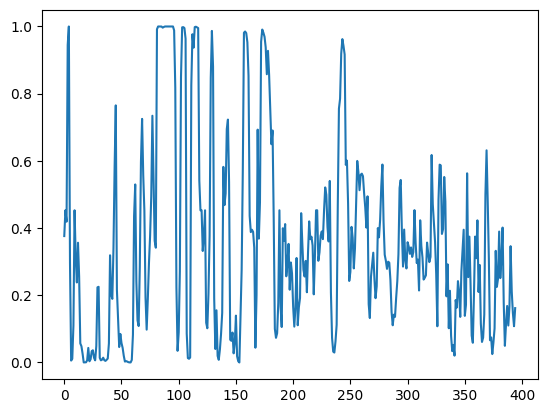

Trial 25 prediction: 0.36113032698631287, label: 0.0


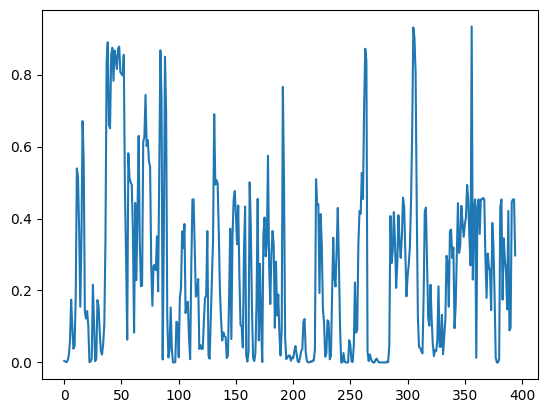

Trial 26 prediction: 0.25116264820098877, label: 0.0


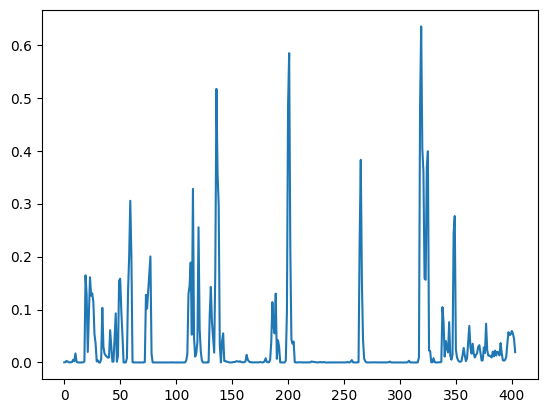

Trial 27 prediction: 0.03663449361920357, label: 0.0


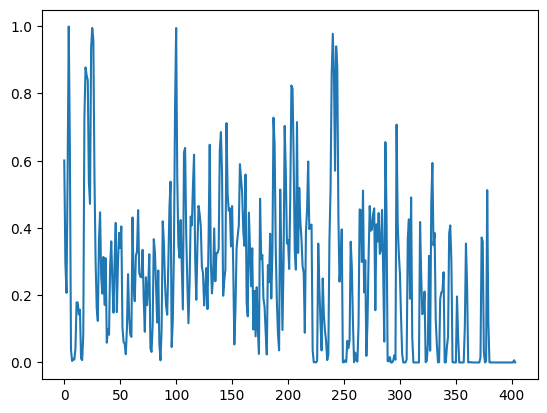

Trial 28 prediction: 0.25537219643592834, label: 0.0


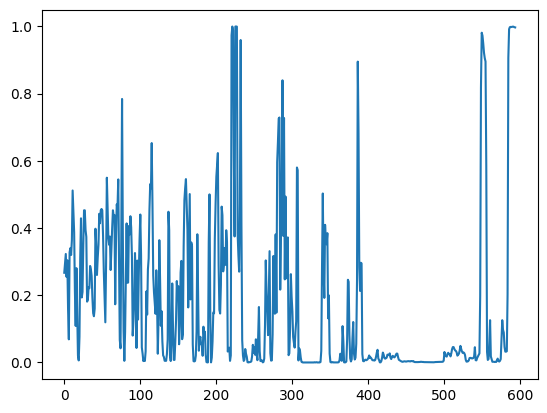

Trial 29 prediction: 0.17472758889198303, label: 1.0


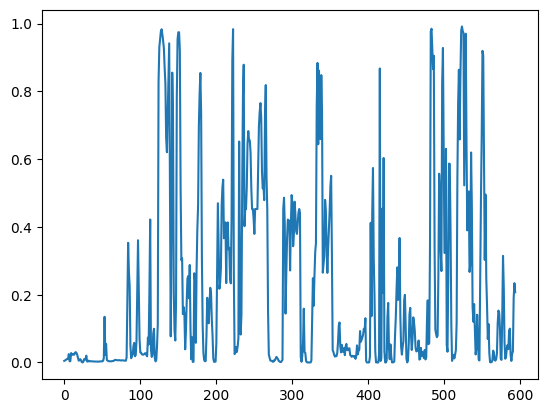

Trial 30 prediction: 0.2253343015909195, label: 1.0
Results for fold: 1
Accuracy: 0.45161290322580644, Recall: 0.05555555555555555, False Positives: 0.0, Specificity: 1.0, Precision: 1.0.


KeyboardInterrupt: 

In [40]:
CNN_mean = assess_window_model(standardised, create_CNN_model, mean_concat, verbose=True)

In [48]:
CNN_mean = assess_window_model(measurements_nosum, create_CNN_model, mean_concat, verbose=True)

Epoch 1/10
451/451 [==============================] - 6s 8ms/step - loss: 0.5849 - accuracy: 0.6993 - val_loss: 1.7312 - val_accuracy: 0.6437
Epoch 2/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4994 - accuracy: 0.7405 - val_loss: 0.7859 - val_accuracy: 0.7060
Epoch 3/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4590 - accuracy: 0.7700 - val_loss: 1.1410 - val_accuracy: 0.6171
Epoch 4/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4297 - accuracy: 0.7847 - val_loss: 1.0749 - val_accuracy: 0.7186
Epoch 5/10
451/451 [==============================] - 3s 6ms/step - loss: 0.4063 - accuracy: 0.8024 - val_loss: 0.8976 - val_accuracy: 0.7372
Trial 0 prediction: 0.774758517742157, label: 1.0
Trial 1 prediction: 0.661322832107544, label: 1.0
Trial 2 prediction: 0.6183010935783386, label: 1.0
Trial 3 prediction: 0.877131462097168, label: 1.0
Trial 4 prediction: 0.821965217590332, label: 1.0
Trial 5 prediction: 0.19925934076309204

Exception ignored in: <function _xla_gc_callback at 0x79369be3e7a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


Trial 0 prediction: 0.6333518624305725, label: 1.0
Trial 1 prediction: 0.37407076358795166, label: 1.0
Trial 2 prediction: 0.29642996191978455, label: 1.0
Trial 3 prediction: 0.4876331090927124, label: 1.0
Trial 4 prediction: 0.3272258937358856, label: 1.0
Trial 5 prediction: 0.3961501717567444, label: 0.0
Trial 6 prediction: 0.5021008849143982, label: 0.0
Trial 7 prediction: 7.574320193270978e-08, label: 0.0
Trial 8 prediction: 0.357962965965271, label: 0.0
Trial 9 prediction: 0.5952414274215698, label: 1.0
Trial 10 prediction: 0.36646243929862976, label: 1.0
Trial 11 prediction: 0.3352751135826111, label: 1.0
Trial 12 prediction: 0.2925967276096344, label: 1.0
Trial 13 prediction: 0.2220063954591751, label: 1.0
Trial 14 prediction: 0.3952237069606781, label: 1.0
Trial 15 prediction: 0.3494757115840912, label: 0.0
Trial 16 prediction: 0.6293619871139526, label: 0.0
Trial 17 prediction: 0.33160462975502014, label: 0.0
Trial 18 prediction: 0.5197097063064575, label: 0.0
Trial 19 predict

In [53]:
CNN_mean = assess_window_model(normalised, create_CNN_model, mean_concat, verbose=True)

Fitting model...
Model fitted.
Trial 0 prediction: 1, label: 1.0
Trial 1 prediction: 0, label: 1.0
Trial 2 prediction: 0, label: 1.0
Trial 3 prediction: 0, label: 1.0
Trial 4 prediction: 1, label: 1.0
Trial 5 prediction: 1, label: 1.0
Trial 6 prediction: 1, label: 1.0
Trial 7 prediction: 0, label: 1.0
Trial 8 prediction: 0, label: 1.0
Trial 9 prediction: 0, label: 0.0
Trial 10 prediction: 0, label: 1.0
Trial 11 prediction: 0, label: 0.0
Trial 12 prediction: 1, label: 0.0
Trial 13 prediction: 0, label: 0.0
Trial 14 prediction: 1, label: 0.0
Trial 15 prediction: 0, label: 1.0
Trial 16 prediction: 0, label: 1.0
Trial 17 prediction: 0, label: 1.0
Trial 18 prediction: 0, label: 1.0
Trial 19 prediction: 0, label: 0.0
Trial 20 prediction: 1, label: 0.0
Trial 21 prediction: 0, label: 0.0
Trial 22 prediction: 0, label: 0.0
Trial 23 prediction: 0, label: 1.0
Trial 24 prediction: 1, label: 1.0
Trial 25 prediction: 0, label: 0.0
Trial 26 prediction: 0, label: 0.0
Trial 27 prediction: 1, label: 0.0

In [55]:
CNN_median = assess_window_model(normalised, create_CNN_model, median_concat, verbose=True)

Fitting model...
Model fitted.
Trial 0 prediction: 0.1550493836402893, label: 1.0
Trial 1 prediction: 0.005560675635933876, label: 1.0
Trial 2 prediction: 0.5436542630195618, label: 1.0
Trial 3 prediction: 0.19538487493991852, label: 1.0
Trial 4 prediction: 0.08976241946220398, label: 1.0
Trial 5 prediction: 0.9516875743865967, label: 1.0
Trial 6 prediction: 0.9932882189750671, label: 1.0
Trial 7 prediction: 0.2466631531715393, label: 1.0
Trial 8 prediction: 0.5104581713676453, label: 1.0
Trial 9 prediction: 3.0552187126886565e-06, label: 0.0
Trial 10 prediction: 0.9212544560432434, label: 1.0
Trial 11 prediction: 0.9735845327377319, label: 0.0
Trial 12 prediction: 0.7304069995880127, label: 0.0
Trial 13 prediction: 0.9406296610832214, label: 0.0
Trial 14 prediction: 0.9999265670776367, label: 0.0
Trial 15 prediction: 0.0008880550158210099, label: 1.0
Trial 16 prediction: 0.0019911814015358686, label: 1.0
Trial 17 prediction: 0.1281132996082306, label: 1.0
Trial 18 prediction: 0.072557

In [58]:
CNN_majority = assess_window_model(standardised, create_CNN_model, majority_concat, verbose=True)

Fitting model...
Model fitted.
Trial 0 prediction: 0, label: 1.0
Trial 1 prediction: 0, label: 1.0
Trial 2 prediction: 0, label: 1.0
Trial 3 prediction: 1, label: 1.0
Trial 4 prediction: 0, label: 1.0
Trial 5 prediction: 1, label: 1.0
Trial 6 prediction: 0, label: 1.0
Trial 7 prediction: 0, label: 1.0
Trial 8 prediction: 0, label: 1.0
Trial 9 prediction: 0, label: 0.0
Trial 10 prediction: 0, label: 1.0
Trial 11 prediction: 0, label: 0.0
Trial 12 prediction: 0, label: 0.0
Trial 13 prediction: 0, label: 0.0
Trial 14 prediction: 0, label: 0.0
Trial 15 prediction: 0, label: 1.0
Trial 16 prediction: 0, label: 1.0
Trial 17 prediction: 0, label: 1.0
Trial 18 prediction: 0, label: 1.0
Trial 19 prediction: 0, label: 0.0
Trial 20 prediction: 0, label: 0.0
Trial 21 prediction: 0, label: 0.0
Trial 22 prediction: 0, label: 0.0
Trial 23 prediction: 0, label: 1.0
Trial 24 prediction: 0, label: 1.0
Trial 25 prediction: 0, label: 0.0
Trial 26 prediction: 0, label: 0.0
Trial 27 prediction: 0, label: 0.0

In [45]:
CNN_sequential = assess_window_model(measurements_nosum, create_CNN_model, sequential_threshold, verbose=True)

Epoch 1/10
451/451 [==============================] - 6s 8ms/step - loss: 0.5902 - accuracy: 0.7005 - val_loss: 1.8623 - val_accuracy: 0.6236
Epoch 2/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4977 - accuracy: 0.7426 - val_loss: 1.4293 - val_accuracy: 0.6617
Epoch 3/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4626 - accuracy: 0.7658 - val_loss: 0.6114 - val_accuracy: 0.7971
Epoch 4/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4310 - accuracy: 0.7826 - val_loss: 0.8163 - val_accuracy: 0.7345
Epoch 5/10
451/451 [==============================] - 3s 7ms/step - loss: 0.4087 - accuracy: 0.7975 - val_loss: 0.8772 - val_accuracy: 0.6693
Epoch 6/10
451/451 [==============================] - 3s 7ms/step - loss: 0.3907 - accuracy: 0.8092 - val_loss: 0.7532 - val_accuracy: 0.7137
Trial 0 prediction: 1, label: 1.0
Trial 1 prediction: 1, label: 1.0
Trial 2 prediction: 1, label: 1.0
Trial 3 prediction: 1, label: 1.0
Trial 4 pred